#efficientnetb3

In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset

!unzip /content/alzheimer-disease-dataset.zip


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")


In [16]:
train_dir = '/content/Alzheimer_Dataset_V2/train'
val_dir   = '/content/Alzheimer_Dataset_V2/val'
test_dir  = '/content/Alzheimer_Dataset_V2/test'

img_size = (300, 300)  # EfficientNetB3 input size
batch_size = 32

datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23788 images belonging to 4 classes.
Found 5097 images belonging to 4 classes.
Found 5099 images belonging to 4 classes.


In [17]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(*img_size, 3), pooling='max')
# base_model.trainable = False  # Optional: freeze base model

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.4),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         6,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,789,683 (41.16 MB)

 Trainable params: 10,702,380 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [18]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)


Epoch 1/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 543s 568ms/step - accuracy: 0.5272 - loss: 1.7847 - val_accuracy: 0.8042 - val_loss: 0.4462
Epoch 2/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 353s 474ms/step - accuracy: 0.8374 - loss: 0.3865 - val_accuracy: 0.9421 - val_loss: 0.1519
Epoch 3/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 351s 472ms/step - accuracy: 0.9540 - loss: 0.1280 - val_accuracy: 0.9559 - val_loss: 0.1335
Epoch 4/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 352s 473ms/step - accuracy: 0.9747 - loss: 0.0748 - val_accuracy: 0.9818 - val_loss: 0.0514
Epoch 5/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 353s 474ms/step - accuracy: 0.9862 - loss: 0.0407 - val_accuracy: 0.9904 - val_loss: 0.0248


In [21]:
model.save("EfficientNetB3_Alzheimer.keras")

In [23]:
model.save_weights("efficientnetb3.weights.h5")


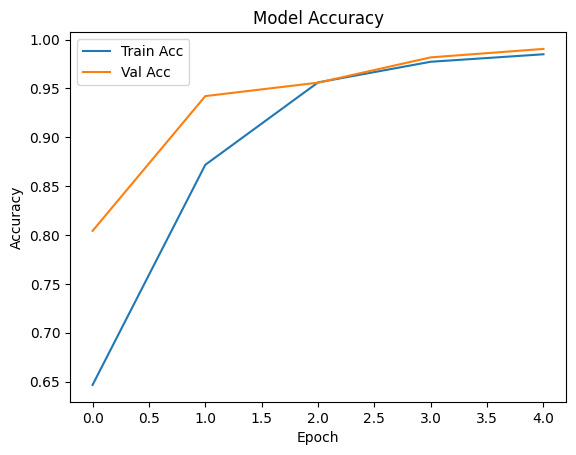

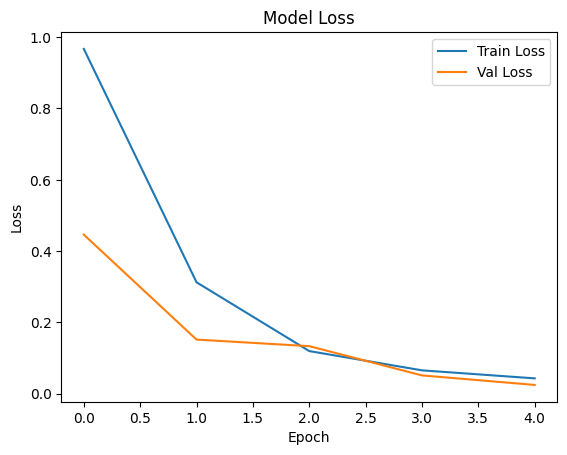

In [24]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       0.99      0.99      0.99      1440
VeryMildDemented       0.99      0.99      0.99      1344

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      5099



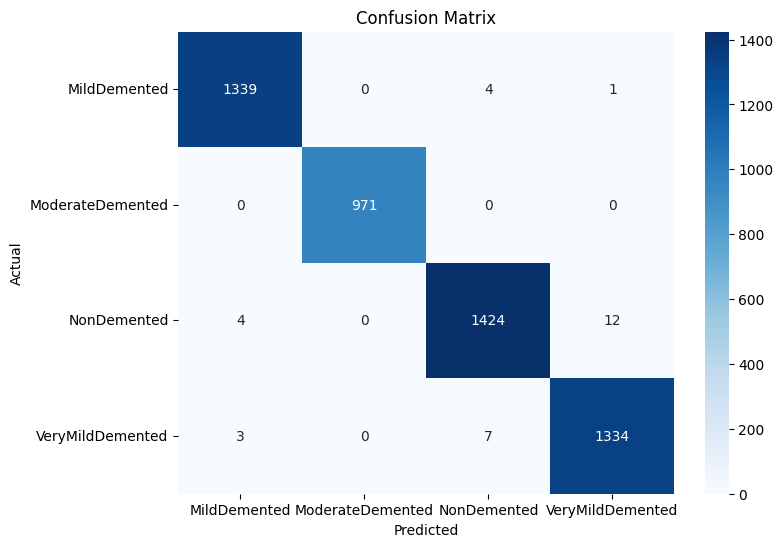

In [25]:
pred_probs = model.predict(test_data)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [26]:
report_dict = classification_report(true_classes, pred_classes, target_names=class_labels, output_dict=True)
f1_df = pd.DataFrame(report_dict).transpose()
f1_df = f1_df[['precision', 'recall', 'f1-score', 'support']]
f1_df.style.background_gradient(cmap='YlGnBu', axis=1).format(precision=2)


,precision,recall,f1-score,support
MildDemented,0.99,1.00,1.00,1344.00
ModerateDemented,1.00,1.00,1.00,971.00
NonDemented,0.99,0.99,0.99,1440.00
VeryMildDemented,0.99,0.99,0.99,1344.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,5099.00
weighted avg,0.99,0.99,0.99,5099.00


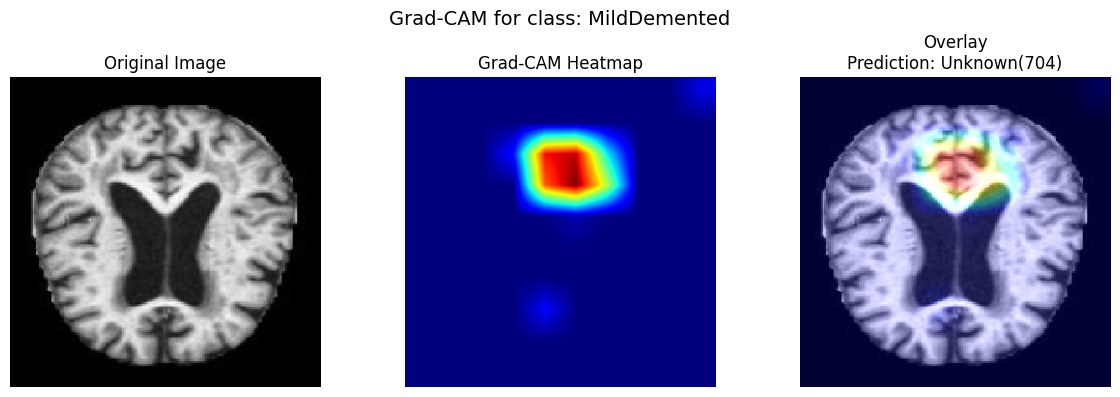

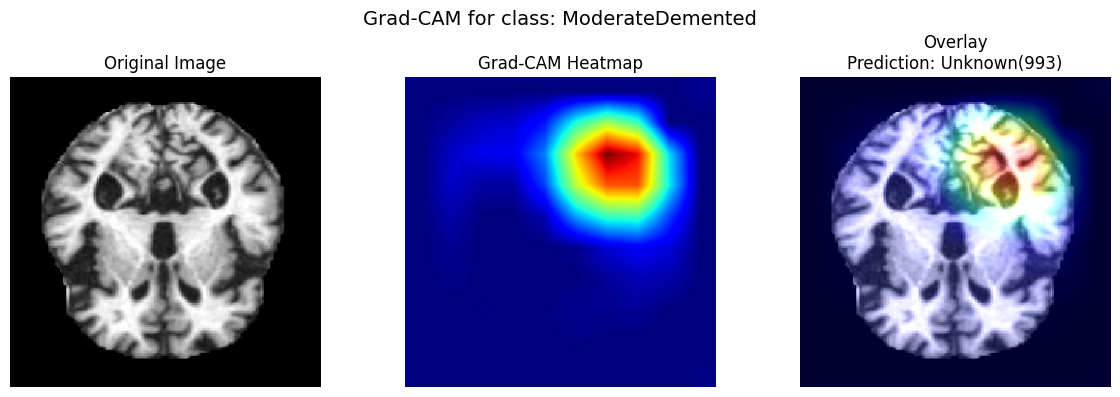

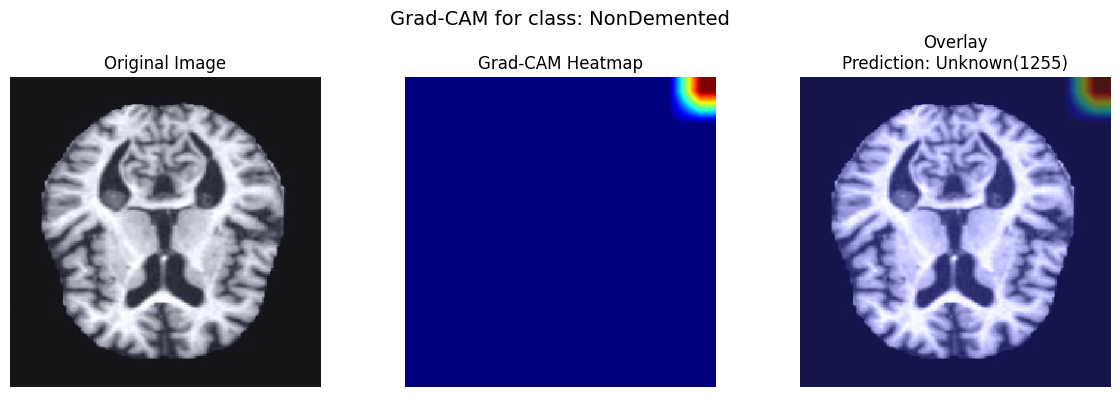

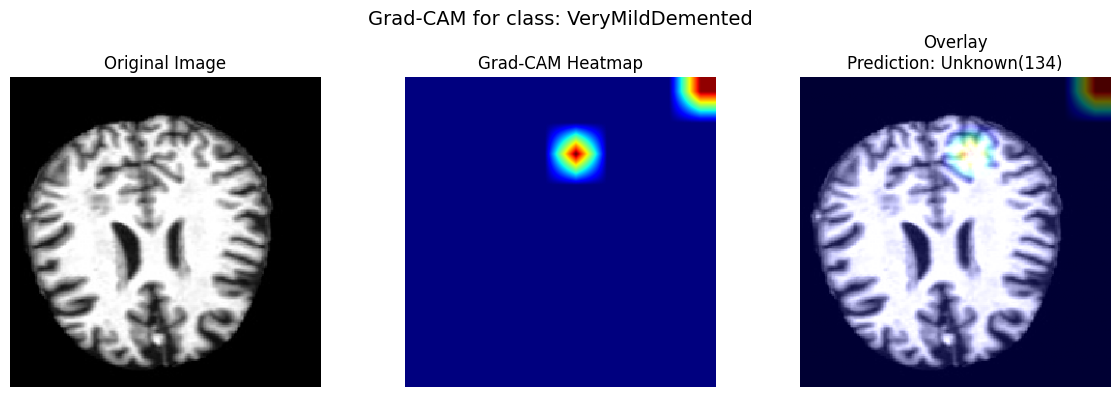

In [30]:
import cv2
import matplotlib.cm as cm
from tensorflow.keras.models import Model

# Class labels
class_labels = list(test_data.class_indices.keys())
label_to_index = test_data.class_indices
index_to_label = {v: k for k, v in label_to_index.items()}

# Access the EfficientNetB3 base model
base_model = model.layers[0]
last_conv_layer_name = "top_activation"  # This is the last conv layer in EfficientNetB3
last_conv_layer = base_model.get_layer(last_conv_layer_name)

# Build Grad-CAM model
grad_model = Model(inputs=base_model.input,
                   outputs=[last_conv_layer.output, base_model.output])

# Loop through each class
for class_idx, class_name in index_to_label.items():
    found = False
    for i in range(len(test_data)):
        images, labels = test_data[i]
        for j in range(len(images)):
            if np.argmax(labels[j]) == class_idx:
                img = np.expand_dims(images[j], axis=0)
                true_label = class_name
                found = True
                break
        if found:
            break

    if not found:
        print(f"⚠️ No sample found for class {class_name}")
        continue

    # Grad-CAM computation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        pred_idx = int(tf.argmax(predictions[0]))  # Convert tensor to int
        loss = predictions[:, pred_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Resize and overlay heatmap
    heatmap_resized = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[1]))
    heatmap_colored = cm.jet(heatmap_resized)[:, :, :3]

    # ✅ FIXED: Proper image rescaling (EfficientNet uses 0–255 input)
    img_orig = np.clip(img[0] / 255.0, 0, 1)

    superimposed = np.clip(heatmap_colored * 0.4 + img_orig, 0, 1)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Grad-CAM for class: {true_label}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed)
    predicted_label = index_to_label.get(pred_idx, f"Unknown({pred_idx})")
    plt.title(f"Overlay\nPrediction: {predicted_label}")

    plt.axis('off')

    plt.tight_layout()
    plt.show()
